In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy
import copy
import qiskit
import json
from qiskit.test.mock import FakeCasablanca
from mitiq import zne
import mitiq
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from qiskit.providers.aer.extensions import SnapshotDensityMatrix
from mitiq.zne.scaling import fold_gates_from_left,fold_gates_at_random, fold_global,fold_gates_from_right
from mitiq.zne.inference import LinearFactory,RichardsonFactory,PolyFactory
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.providers.aer import AerSimulator
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper,ParityMapper
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit.quantum_info import Pauli
from qiskit.chemistry import FermionicOperator
from qiskit.aqua.operators.legacy import op_converter
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister
from qiskit import Aer
from qiskit.circuit.random import random_circuit
from joblib import Parallel,delayed
from qiskit.aqua.operators import WeightedPauliOperator,Z2Symmetries
from qiskit.chemistry.components.variational_forms import UCCSD
import scipy

In [2]:
h_N=numpy.eye(8)
h_Sz=numpy.block([[numpy.eye(4),numpy.zeros((4,4))],
                  [numpy.zeros((4,4)),-1*numpy.eye(4)]])
def qubitOp(h1,h2):  
    fer_op=fermionic_op_builder.build_ferm_op_from_ints(h1,h2)
    qubit_conv = QubitConverter(ParityMapper(), two_qubit_reduction=True, z2symmetry_reduction="auto")
    qubit_op = qubit_conv.convert(fer_op, len(h1)//2)
    #mapper=JordanWignerMapper()
    #qubit_op=mapper.map(fer_op)
    return qubit_op 

In [3]:
qubitN=qubitOp(h_N,numpy.zeros((8,8,8,8)))
N_matrix=qubitN.to_matrix()
qubitSz=qubitOp(h_Sz,numpy.zeros((8,8,8,8)))
Sz_matrix=qubitSz.to_matrix()
def NumParticlesBitstring(bit_str):
    state_vector=numpy.zeros(2**6)
    state_vector[int(bit_str,2)]=1
    return numpy.real(state_vector@N_matrix@state_vector.T)
def SpinBitstring(bit_str):
    state_vector=numpy.zeros(2**6)
    state_vector[int(bit_str,2)]=1
    return numpy.real(state_vector@Sz_matrix@state_vector.T)

def filter_bitstrings(counts):
    Keys=list(counts.keys())
    Vals=list(counts.values())
    newCounts={}
    for i in range(len(Keys)):
        n=NumParticlesBitstring(Keys[i])
        s=SpinBitstring(Keys[i])
        if (numpy.abs(n-4)<1e-3 and  numpy.abs(s)<1e-3):
            newCounts[Keys[i]]=Vals[i]
        else:
            continue
    return newCounts        

In [4]:
from mitiq.zne.inference import RichardsonFactory,AdaExpFactory
# Initialize extrapolation method
scale_factors=[1.0,2.0,3.0]
def zne_Richardson_inference(scale_factors,noisy_expectation_values):
    fac = RichardsonFactory(scale_factors)
    # Load data into extrapolation factory
    for x, y in zip(scale_factors, noisy_expectation_values):
        fac.push({"scale_factor": x}, y)

    # Run extrapolation
    zero_noise = fac.reduce()
    return zero_noise,fac
def zne_adaexp_inference(steps,asymptote,noisy_expectation_values):
    fac = AdaExpFactory(steps=3, asymptote=0.001)
    # Load data into extrapolation factory
    for x, y in zip([1.   , 2.   , 2.634], noisy_expectation_values):
        fac.push({"scale_factor": x}, y)
    # Run extrapolation
    zero_noise = fac.reduce()
    return zero_noise,fac

def mitigated_estimateH_1(noisy_estimates):
        E1_estm=[]
        for i in range(0,len(noisy_estimates),3):
            Energy_vals=noisy_estimates[i:i+3]
            zero_noise_estimate,fac2=zne_Richardson_inference([1,2,3],Energy_vals)
            E1_estm.append([[zero_noise_estimate]+Energy_vals]+[fac2])
        return E1_estm
def mitigated_estimateH_2(noisy_estimates):
        E1_estm=[]
        for i in range(0,len(noisy_estimates),3):
            Energy_vals=noisy_estimates[i:i+3]
            zero_noise_estimate,fac2=zne_Richardson_inference([1,2,3],Energy_vals)
            E1_estm.append([[zero_noise_estimate]+Energy_vals]+[fac2])
        return E1_estm
def mitigated_estimateH_3(noisy_estimates):
    E1_estm=[]
    for i in range(0,len(noisy_estimates),3):
        Energy_vals=noisy_estimates[i:i+3]
        zero_noise_estimate,fac3=zne_Richardson_inference([1,2,3],Energy_vals)
        E1_estm.append([[zero_noise_estimate]+Energy_vals]+[fac3])
    return E1_estm
def EnergyComponentFromSampling(counts_arr,Op):
    noisy_value_arr=[]
    for i in range(len(counts_arr)):
        counts=counts_arr[i]
        rho=numpy.zeros((2**6,2**6))
        Keys=list(counts.keys())
        Vals=list(counts.values())
        Num=len(Vals)
        tot=sum(Vals)
        for i in range(len(Keys)):
            rho[int(Keys[i],2)][int(Keys[i],2)]=Vals[i]/tot
        noisy_value=numpy.real(numpy.sum(numpy.diag(rho@Op.to_matrix())))
        noisy_value_arr.append(noisy_value)
    return noisy_value_arr

In [5]:
def NumberFluctuation(counts_arr):
    NumberFluc_arr=[]
    NumberMean_arr=[]
    for i in range(len(counts_arr)):
        counts=counts_arr[i]
        rho=numpy.zeros((2**6,2**6))
        Keys=list(counts.keys())
        Vals=list(counts.values())
        Num=len(Vals)
        tot=sum(Vals)
        for i in range(len(Keys)):
            rho[int(Keys[i],2)][int(Keys[i],2)]=Vals[i]/tot         
        N2=numpy.real(numpy.sum(numpy.diag(rho@N_matrix@N_matrix)))
        N=numpy.real(numpy.sum(numpy.diag(rho@N_matrix)))
        DeltaN2=N2-N*N
        NumberFluc_arr.append(DeltaN2)
        NumberMean_arr.append(N)
    return NumberFluc_arr,NumberMean_arr
def SpinFluctuation(counts_arr):
    SpinFluc_arr=[]
    SpinMean_arr=[]
    for i in range(len(counts_arr)):
        counts=counts_arr[i]
        rho=numpy.zeros((2**6,2**6))
        Keys=list(counts.keys())
        Vals=list(counts.values())
        Num=len(Vals)
        tot=sum(Vals)
        for i in range(len(Keys)):
            rho[int(Keys[i],2)][int(Keys[i],2)]=Vals[i]/tot         
        Sz2=numpy.real(numpy.sum(numpy.diag(rho@Sz_matrix@Sz_matrix)))
        Sz=numpy.real(numpy.sum(numpy.diag(rho@Sz_matrix)))
        DeltaSz2=Sz2-Sz*Sz
        SpinFluc_arr.append(DeltaSz2)
        SpinMean_arr.append(Sz)
    return SpinFluc_arr,SpinMean_arr

In [6]:
#load data
#load three Hamiltonian subparts
fileObject = open("H1.json", "r")
jsonContent = fileObject.read()
H_1 = json.loads(jsonContent)
fileObject = open("H2.json", "r")
jsonContent = fileObject.read()
H_2 = json.loads(jsonContent)
fileObject = open("H3.json", "r")
jsonContent = fileObject.read()
H_3 = json.loads(jsonContent)
H_1=PauliSumOp.from_list(H_1)
H_2=PauliSumOp.from_list(H_2)
H_3=PauliSumOp.from_list(H_3)
#load three different circuits with pre-rotation gates appended to the GS ansatz for measuring three parts
circ1=QuantumCircuit.from_qasm_file('qc1.txt')
circ2=QuantumCircuit.from_qasm_file('qc2.txt')
circ3=QuantumCircuit.from_qasm_file('qc3.txt')

In [7]:
state1=numpy.array(execute(circ1,Aer.get_backend('statevector_simulator')).result().get_statevector())
ideal_value1=numpy.real(numpy.conjugate(state1)@H_1.to_matrix()@state1)
state2=numpy.array(execute(circ2,Aer.get_backend('statevector_simulator')).result().get_statevector())
ideal_value2=numpy.real(numpy.conjugate(state2)@H_2.to_matrix()@state2)
state3=numpy.array(execute(circ3,Aer.get_backend('statevector_simulator')).result().get_statevector())
ideal_value3=numpy.real(numpy.conjugate(state3)@H_3.to_matrix()@state3)
E_exact=ideal_value1+ideal_value2+ideal_value3
E_exact

-19.184209602095095

In [9]:
fileObject = open("circuit1_counts_filtered_new.json", "r")
jsonContent = fileObject.read()
json_arr=jsonContent.split('\n')
counts1_arr_filtered=[eval(json_arr[i]) for i in range(len(json_arr)-1) if i%2==0]
valid_measurements_circ1_frac=[eval(json_arr[i].split('measurements ')[1]) for i in range(len(json_arr)-1) if i%2==1]
fileObject = open("circuit2_counts_filtered_new.json", "r")
jsonContent = fileObject.read()
json_arr=jsonContent.split('\n')
counts2_arr_filtered=[eval(json_arr[i]) for i in range(len(json_arr)-1) if i%2==0]
valid_measurements_circ2_frac=[eval(json_arr[i].split('measurements ')[1]) for i in range(len(json_arr)-1) if i%2==1]
fileObject = open("circuit3_counts_filtered_new.json", "r")
jsonContent = fileObject.read()
json_arr=jsonContent.split('\n')
counts3_arr_filtered=[eval(json_arr[i]) for i in range(len(json_arr)-1) if i%2==0]
valid_measurements_circ3_frac=[eval(json_arr[i].split('measurements ')[1]) for i in range(len(json_arr)-1) if i%2==1]
fileObject = open("circuit1_counts_not_filtered_new.json", "r")
jsonContent = fileObject.read()
json_arr=jsonContent.split('\n')
counts1_arr_not_filtered=[eval(json_arr[i]) for i in range(len(json_arr)-1)]
fileObject = open("circuit2_counts_not_filtered_new.json", "r")
jsonContent = fileObject.read()
json_arr=jsonContent.split('\n')
counts2_arr_not_filtered=[eval(json_arr[i]) for i in range(len(json_arr)-1)]
fileObject = open("circuit3_counts_not_filtered_new.json", "r")
jsonContent = fileObject.read()
json_arr=jsonContent.split('\n')
counts3_arr_not_filtered=[eval(json_arr[i]) for i in range(len(json_arr)-1)]
E1_arr_filtered=EnergyComponentFromSampling(counts1_arr_filtered,H_1)
E2_arr_filtered=EnergyComponentFromSampling(counts2_arr_filtered,H_2)
E3_arr_filtered=EnergyComponentFromSampling(counts3_arr_filtered,H_3)
E1_estimates_filtered=mitigated_estimateH_1(E1_arr_filtered)
E2_estimates_filtered=mitigated_estimateH_2(E2_arr_filtered)
E3_estimates_filtered=mitigated_estimateH_3(E3_arr_filtered)
E_estimates=[]
for i in range(len(E1_estimates_filtered)):
    E_estm1,fac1=E1_estimates_filtered[i]
    E_estm2,fac2=E2_estimates_filtered[i]
    E_estm3,fac3=E3_estimates_filtered[i]
    E_estimates.append(numpy.array(E_estm1)+numpy.array(E_estm2)+numpy.array(E_estm3))
    #print(i,numpy.array(E_estm1)+numpy.array(E_estm2)+numpy.array(E_estm3),'\n')

In [10]:
E_estimates=numpy.array(E_estimates)
numpy.std(E_estimates[0:5,1:],axis=0)
len(E_estimates)

10

In [11]:
numpy.sum(E_estimates[0:5,0])/5

-19.034522194845557

In [12]:
numpy.abs(100*((numpy.sum(E_estimates[0:5,0])/5-E_exact)/E_exact))

0.7802636144738018

In [13]:
valid_measurements_circ1_frac_new=numpy.array(valid_measurements_circ1_frac).reshape(10,3)
valid_measurements_circ2_frac_new=numpy.array(valid_measurements_circ2_frac).reshape(10,3)
valid_measurements_circ3_frac_new=numpy.array(valid_measurements_circ3_frac).reshape(10,3)

In [14]:
E1_arr_filtered_new=numpy.array(E1_arr_filtered).reshape(10,3)
E2_arr_filtered_new=numpy.array(E2_arr_filtered).reshape(10,3)
E3_arr_filtered_new=numpy.array(E3_arr_filtered).reshape(10,3)

In [15]:
NumberFluc1_arr,NumberMean1_arr=NumberFluctuation(counts1_arr_not_filtered)
NumberFluc2_arr,NumberMean2_arr=NumberFluctuation(counts2_arr_not_filtered)
NumberFluc3_arr,NumberMean3_arr=NumberFluctuation(counts3_arr_not_filtered)
SpinFluc1_arr,SpinMean1_arr=SpinFluctuation(counts1_arr_not_filtered)
SpinFluc2_arr,SpinMean2_arr=SpinFluctuation(counts2_arr_not_filtered)
SpinFluc3_arr,SpinMean3_arr=SpinFluctuation(counts3_arr_not_filtered)

In [16]:
len(E1_estimates_filtered)

10

In [17]:
x_vals=numpy.linspace(0,3,10)
energy_vals_arr=[]
for i in range(len(E1_estimates_filtered)):
    
    E_estm1,fac1=E1_estimates_filtered[i]
    E_estm2,fac2=E2_estimates_filtered[i]
    E_estm3,fac3=E3_estimates_filtered[i]
    energyVals1=fac1.get_extrapolation_curve()
    energyVals2=fac2.get_extrapolation_curve()
    energyVals3=fac3.get_extrapolation_curve()
    energy_vals=[energyVals1(scale_fac)+energyVals2(scale_fac)+energyVals3(scale_fac) for scale_fac in x_vals]
    energy_vals_arr.append(energy_vals)

In [18]:
std_dev_optimized_subset=numpy.std(energy_vals_arr[0:5],axis=0)
std_dev_optimized_subset

array([0.1926046 , 0.11103391, 0.04571765, 0.01951244, 0.0502724 ,
       0.07200099, 0.07957971, 0.07268289, 0.05167487, 0.02143235])

In [20]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(2,2,figsize=(17,12))
def func(x,a,b,c):
    return a*x*x+b*x+c
#all the ten measurements

#calculation average over runs
w_E1=numpy.average(E1_arr_filtered_new,axis=0)
w_E2=numpy.average(E2_arr_filtered_new,axis=0)
w_E3=numpy.average(E3_arr_filtered_new,axis=0)
w_E=w_E1+w_E2+w_E3

#calculating stdev over runs
std_dev_full=numpy.std(energy_vals_arr[0:10],axis=0)# standard deviation at all points
std=numpy.std(numpy.array(E1_arr_filtered_new)+numpy.array(E2_arr_filtered_new)+numpy.array(E3_arr_filtered_new),axis=0)# standard deviation at only three points

#fitting
popt, pcov = scipy.optimize.curve_fit(func,[1,2,3],w_E,sigma=std,absolute_sigma=True)
x_vals=numpy.linspace(0,3,10)
E_zne=func(x_vals, popt[0],popt[1],popt[2])[0]

ax[1,0].plot(x_vals, func(x_vals, popt[0],popt[1],popt[2]), 'k',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
#y1 = numpy.array(func(x_vals, popt[0], popt[1],popt[2])) +numpy.array(std_dev_full)
y2 = numpy.array(func(x_vals, popt[0], popt[1],popt[2])) -numpy.array(std_dev_full)

#ax[1,0].plot(x_vals, y1, 'b--')
#ax[1,0].plot(x_vals, y2, 'b--')

ax[1,0].plot([0,1,2,3],list([E_zne])+list(w_E),marker='o',markersize=8,markeredgecolor="black",alpha=0.7,linestyle='',label='run-%s'%(i+1))
ax[1,0].errorbar([0,1,2,3],list([E_zne])+list(w_E),[E_zne-y2[0]]+list(std),linestyle='',ms=10, mew=4,color='k',elinewidth=3,capsize=3)
print('zne error',E_zne-y2[0],"energy",E_zne)
#ax[1,0].fill_between(x_vals, y1, y2, facecolor="gray", alpha=0.15)
ax[1,0].set_ylabel('Energy',fontsize=15)
ax[1,0].tick_params(labelsize=15)
ax[1,0].set_xlim([-0.05,3.1])
ax[1,0].plot(x_vals,E_exact*numpy.ones(len(x_vals)),color='r',linestyle='--')
ax[1,0].set_xticks([0,1,2,3])
ax[1,0].set_xlabel('Scale Factor',fontsize=15)
#optimized subset of measurements based on N and Sz filtering
#mean
avg_E_runs=numpy.average(E_estimates[:5,1:],axis=0)
#stdev
std=numpy.std(E_estimates[0:5,1:],axis=0)
#fitting
popt, pcov = scipy.optimize.curve_fit(func,[1,2,3],avg_E_runs,sigma=std,absolute_sigma=True)


ax[0,0].plot(x_vals, func(x_vals, popt[0],popt[1],popt[2]), 'k',
         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
std_dev_optimized_subset=numpy.std(energy_vals_arr[0:5],axis=0)
#y1 = numpy.array(func(x_vals, popt[0], popt[1],popt[2])) +numpy.array(std_dev_optimized_subset)
y2 = numpy.array(func(x_vals, popt[0], popt[1],popt[2])) -numpy.array(std_dev_optimized_subset)
#ax[0,0].plot(x_vals, y1, 'b--')
#ax[0,0].plot(x_vals, y2, 'b--')
ax[0,0].plot(x_vals,E_exact*numpy.ones(len(x_vals)),color='r',linestyle='--')
ax[0,0].plot([0,1,2,3],list([numpy.sum(E_estimates[0:5,0])/5])+list(avg_E_runs),marker='o',markersize=8,markeredgecolor="black",alpha=0.7,linestyle='',label='run-%s'%(i+1))
ax[0,0].errorbar([0,1,2,3],list([numpy.sum(E_estimates[0:5,0])/5])+list(avg_E_runs),[numpy.sum(E_estimates[0:5,0])/5-y2[0]]+list(numpy.std(E_estimates[0:5,1:],axis=0)),linestyle='',ms=10, mew=4,color='k',elinewidth=3,capsize=3)
#ax[0,0].fill_between(x_vals, y1, y2, facecolor="gray", alpha=0.15)
#ax[0,0].set_xlabel('Scale Factor',fontsize=15)
ax[0,0].set_ylabel('Energy',fontsize=15)
ax[0,0].tick_params(labelsize=15)
ax[0,0].set_xlim([-0.05,3.1])
ax[0,0].set_xticks([0,1,2,3])
newax = fig.add_axes([0.07,-0.02,0.5,0.5], anchor='NE', zorder=1)

#inset layout of qubits
im = plt.imread('layout_ibmQ_casablanca.png')
newax.imshow(im)
newax.axis('off')
ax2=inset_axes(ax[0,0], width="50%", height="75%",bbox_to_anchor=(0.5, 0.17, .7, .5),bbox_transform=ax[0,0].transAxes, loc=3)
ax2.plot([0,1,2,3],list([numpy.sum(E_estimates[0:5,0])/5])+list(avg_E_runs)-E_exact,marker='o',color='r',markeredgecolor="black",alpha=0.7,linestyle='')
ax2.set_yticks([10**-1,10**0])
ax2.set_ylim([10**-1,5])
ax2.set_yscale('log')
ax2.set_xlabel('Scale Factor',fontsize=14)
ax2.set_ylabel(r'$|E-E_{GS}|$',fontsize=14)
ax2.tick_params(labelsize=13)
#plotting number of particles error and Sz mag. error
for i in range(len(E1_estimates_filtered)):
    Num=NumberMean1_arr[3*i:3*i+3]
    Spin=SpinMean1_arr[3*i:3*i+3]
    frac_valid_measurements=(1/3.)*(numpy.array(valid_measurements_circ1_frac[3*i:3*i+3])+numpy.array(valid_measurements_circ2_frac[3*i:3*i+3])+numpy.array(valid_measurements_circ3_frac[3*i:3*i+3]))
    ax[0,1].plot([1,2,3],numpy.abs(numpy.array(Num)-4),linestyle='-',marker='o',markersize=10,markeredgecolor="black",alpha=0.7,label='run-%s'%(i+1))
    ax[0,1].set_ylabel(r'$|N-4|$',fontsize=15)
    ax[0,1].tick_params(labelsize=15)
    ax[0,1].set_xlim([0.9,3.1])
    ax[0,1].set_xticks([1,2,3])
    ax[1,1].plot([1,2,3],numpy.abs(numpy.array(Spin)),linestyle='-',marker='o',markersize=10,markeredgecolor="black",alpha=0.7,label='run-%s'%(i+1))
    ax[1,1].set_xlabel('Scale Factor',fontsize=15)
    ax[1,1].set_ylabel(r'$|Sz|$',fontsize=15)
    ax[1,1].tick_params(labelsize=15)
    ax[1,1].set_xlim([0.9,3.1])
    ax[1,1].set_xticks([1,2,3])
    plt.tight_layout()
arr=[[0,0],[1,0],[0,1],[1,1]]    
for i,label in enumerate(['(a)', '(b)', '(c)', '(d)']):
    ax[arr[i][0],arr[i][1]].text(-0.1, -0.05, label, transform=ax[arr[i][0],arr[i][1]].transAxes,fontsize=17)    
plt.savefig('EnergyNoiseScaling.png')    

zne error 0.7157829692489877 energy -18.564976368205308


[-19.24708693 -17.27206111 -15.936133   -15.23930262]
[-18.71025691 -17.29642224 -16.15574497 -15.28822509]
[-19.11017749 -17.24500233 -15.96505059 -15.27032227]
[-18.93259157 -17.29063466 -16.06110124 -15.2439913 ]
[-19.17249808 -17.29526769 -15.98132682 -15.23067547]
[-18.30397844 -17.02707221 -16.03031297 -15.31370074]
[-18.20946732 -16.92973199 -15.99581794 -15.40772518]
[-18.68382146 -16.95973515 -15.88540606 -15.46083418]
[-18.61861489 -17.00348688 -15.91524925 -15.35390201]
[-16.6612706  -15.81692747 -15.49542801 -15.69677221]


FileNotFoundError: [Errno 2] No such file or directory: 'estimate_datfiles/gs_energy_determination_eg_model_all_data_points1.png'

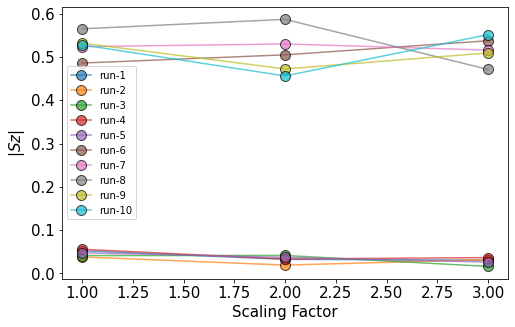

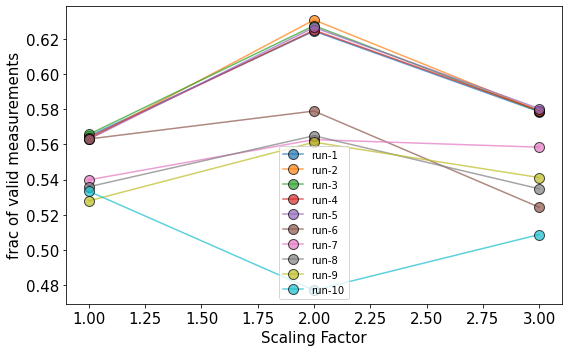

In [21]:
import matplotlib.pyplot as plt
scale_factor_list=numpy.linspace(0,3,15)
fig,ax=plt.subplots(1,figsize=(12,10))
fig2,ax2=plt.subplots(1,figsize=(8,5))
fig3,ax3=plt.subplots(1,figsize=(8,5))
fig4,ax4=plt.subplots(1,figsize=(8,5))
for i in range(len(E1_estimates_filtered)):
    
    E_estm1,fac1=E1_estimates_filtered[i]
    E_estm2,fac2=E2_estimates_filtered[i]
    E_estm3,fac3=E3_estimates_filtered[i]


    print(numpy.array(E_estm1)+numpy.array(E_estm2)+numpy.array(E_estm3))
    energyVals1=fac1.get_extrapolation_curve()
    energyVals2=fac2.get_extrapolation_curve()
    energyVals3=fac3.get_extrapolation_curve()
    energy_vals=[energyVals1(scale_fac)+energyVals2(scale_fac)+energyVals3(scale_fac) for scale_fac in scale_factor_list]

    ax.plot(scale_factor_list,energy_vals,linestyle='--',color='k',linewidth=1.5)
    ax.plot([0,1,2,3],numpy.array(E_estm1)+numpy.array(E_estm2)+numpy.array(E_estm3),marker='o',markersize=10,markeredgecolor="black",alpha=0.7,linestyle='',label='run-%s'%(i+1))
    ax.plot(scale_factor_list,E_exact*numpy.ones(len(scale_factor_list)),color='k')
    ax.set_xlabel('Scaling Factor',fontsize=15)
    ax.set_ylabel('Energy',fontsize=15)
    ax.tick_params(labelsize=15)
    ax.set_xlim([-0.1,3.1])
    Num=NumberMean1_arr[3*i:3*i+3]
    Spin=SpinMean1_arr[3*i:3*i+3]
    frac_valid_measurements=(1/3.)*(numpy.array(valid_measurements_circ1_frac[3*i:3*i+3])+numpy.array(valid_measurements_circ2_frac[3*i:3*i+3])+numpy.array(valid_measurements_circ3_frac[3*i:3*i+3]))
    ax2.plot([1,2,3],numpy.abs(numpy.array(Num)-4),linestyle='-',marker='o',markersize=10,markeredgecolor="black",alpha=0.7,label='run-%s'%(i+1))
    ax2.set_xlabel('Scaling Factor',fontsize=15)
    ax2.set_ylabel(r'$|N-4|$',fontsize=15)
    ax2.tick_params(labelsize=15)
    ax2.set_xlim([0.9,3.1])
    ax3.plot([1,2,3],numpy.abs(numpy.array(Spin)),linestyle='-',marker='o',markersize=10,markeredgecolor="black",alpha=0.7,label='run-%s'%(i+1))
    ax3.set_xlabel('Scaling Factor',fontsize=15)
    ax3.set_ylabel(r'$|Sz|$',fontsize=15)
    ax3.tick_params(labelsize=15)
    ax3.set_xlim([0.9,3.1])
    ax4.plot([1,2,3],frac_valid_measurements,linestyle='-',marker='o',markersize=10,markeredgecolor="black",alpha=0.7,label='run-%s'%(i+1))
    ax4.set_xlabel('Scaling Factor',fontsize=15)
    ax4.set_ylabel(r'frac of valid measurements',fontsize=15)
    ax4.tick_params(labelsize=15)
    ax4.set_xlim([0.9,3.1])
    plt.tight_layout()
    
    #plt.show()
ax.legend(fontsize=10)    
ax2.legend(fontsize=10)    
ax3.legend(fontsize=10)   
ax4.legend(fontsize=10)   
fig.savefig('gs_energy_determination_eg_model_all_data_points1.png')
fig2.savefig('Num_error.png')
fig3.savefig('Spin_error.png')
fig4.savefig('esfrac_valid_measure.png')